In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

In [4]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)

data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [5]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [6]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


In [7]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 2e-5

In [8]:
# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = [2,2,2,2]

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, i) for i in self.num_labels])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        
        logits = [torch.sigmoid(logit) for logit in logits]
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:, i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss

            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

# Define compute metrics for evaluation
def compute_metrics_multi(p):
    logits = p.predictions # logits list<tensor(bs, num_label)> ~ list of batch prediction per class 
    label_batch = p.label_ids

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = [torch.topk(torch.tensor(logit, dtype=torch.float), 1)[1] for logit in logits] # list<tensor(bs)>
    batch_size = label_batch.shape[0]
    num_label = len(hyp)
    for i in range(batch_size):
        hyps = []
        labels = torch.tensor(label_batch[i,:], dtype=torch.float)
        for j in range(num_label):
            hyps.append(hyp[j][i].item())

        hyps = torch.tensor(hyps, dtype=torch.float)
        list_hyp.append(hyps)
        list_label.append(labels)
    
    accuracy = accuracy_score(list_label, list_hyp)
    # print(accuracy)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(list_label, list_hyp, average='micro', zero_division=0)
    f1_macro = f1_score(list_label, list_hyp, average='macro', zero_division=0)

    # print(classification_report(list_label, list_hyp, zero_division=0, target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [10]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [11]:
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)

def get_dataloaders(sequence_length, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=num_workers, worker_init_fn=seed_worker,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=num_workers, worker_init_fn=seed_worker,
    )

    return train_loader, val_loader

In [12]:
manager = Manager()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

In [ ]:
def train_model(sequence_length, model_name, metrics, seed=42, layers_freezed=6, trial=1, num_workers=4):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < layers_freezed:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    train_loader, val_loader = get_dataloaders(sequence_length, num_workers)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None

    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()
        
        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            best_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'model-{BATCH_SIZE}-{sequence_length}-{layers_freezed}-{trial}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    if accelerator.is_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])
        
    accelerator.print(f"\nAccuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])

In [14]:
# Tokenize each text and calculate their lengths
token_lengths = [len(tokenizer.tokenize(text)) for text in X_train]

# Calculate the average length
average_length = sum(token_lengths) / len(token_lengths)
max_length = max(token_lengths)

print("Average length of tokenized text:", average_length)
print("Max token length:", max_length)

Average length of tokenized text: 54.3126407204889
Max token length: 2591


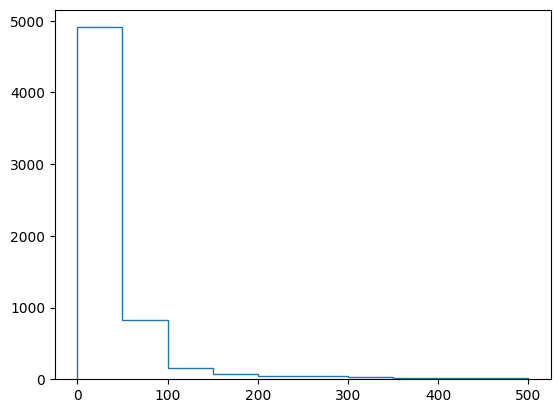

In [15]:
counts, bins = np.histogram(token_lengths, range=(0, 500))
plt.stairs(counts, bins)
plt.show()

# HYPERPARAMETER TUNING

In [ ]:
sizes = [16, 32]
lengths = [64, 80, 96, 128]

used_sizes = []
used_lengths = []

for size in sizes:
    BATCH_SIZE = size
    for length in lengths:
        print("=" * 50)
        print(f"Batch size: {BATCH_SIZE}, sequence length: {length}")
        used_sizes.append(BATCH_SIZE)
        used_lengths.append(length)
        
        args = (length, 'indobenchmark/indobert-base-p1', (accuracies, f1_micros, f1_macros), 42, 6, 1)
        notebook_launcher(train_model, args, num_processes=2)

Batch size: 16, sequence length: 64
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.8922, F1 Micro: 0.7289, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.8991, F1 Micro: 0.7635, F1 Macro: 0.7621
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9013, F1 Micro: 0.7577, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.129, Accuracy: 0.8956, F1 Micro: 0.7673, F1 Macro: 0.765
Epoch 5/10, Train Loss: 0.0913, Accuracy: 0.8962, F1 Micro: 0.759, F1 Macro: 0.7517
Epoch 6/10, Train Loss: 0.0611, Accuracy: 0.8975, F1 Micro: 0.755, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.9005, F1 Micro: 0.7697, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0339, Accuracy: 0.8925, F1 Micro: 0.7567, F1 Macro: 0.7525
Epoch 9/10, Train Loss: 0.0229, Accuracy: 0.8992, F1 Micro: 0.7571, F1 Macro: 0.7513
Epoch 10/10, Train Loss: 0.0204, Accuracy: 0.9013, F1 Micro: 0.7633, F1 Macro: 0.7515

Accuracy: 0.9005, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3252, Accuracy: 0.8952, F1 Micro: 0.7482, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9031, F1 Micro: 0.7662, F1 Macro: 0.7639
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9007, F1 Micro: 0.7608, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1225, Accuracy: 0.9015, F1 Micro: 0.7689, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0882, Accuracy: 0.9005, F1 Micro: 0.7733, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0575, Accuracy: 0.905, F1 Micro: 0.7736, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.9026, F1 Micro: 0.7773, F1 Macro: 0.7703
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9015, F1 Micro: 0.7673, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9047, F1 Micro: 0.7792, F1 Macro: 0.7726
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3244, Accuracy: 0.8933, F1 Micro: 0.7386, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.9021, F1 Micro: 0.7709, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9056, F1 Micro: 0.7779, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.121, Accuracy: 0.9023, F1 Micro: 0.783, F1 Macro: 0.7795
Epoch 5/10, Train Loss: 0.0845, Accuracy: 0.8999, F1 Micro: 0.7639, F1 Macro: 0.7521
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.9024, F1 Micro: 0.776, F1 Macro: 0.7695
Epoch 7/10, Train Loss: 0.04, Accuracy: 0.9031, F1 Micro: 0.7805, F1 Macro: 0.7746
Epoch 8/10, Train Loss: 0.0304, Accuracy: 0.9061, F1 Micro: 0.7813, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9043, F1 Micro: 0.7842, F1 Macro: 0.7814
Epoch 10/10, Train Loss: 0.0195, Accuracy: 0.9058, F1 Micro: 0.7817, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3236, Accuracy: 0.894, F1 Micro: 0.736, F1 Macro: 0.7285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2243, Accuracy: 0.9058, F1 Micro: 0.7794, F1 Macro: 0.7758
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9029, F1 Micro: 0.7727, F1 Macro: 0.7692
Epoch 4/10, Train Loss: 0.1241, Accuracy: 0.9034, F1 Micro: 0.766, F1 Macro: 0.7594
Epoch 5/10, Train Loss: 0.0805, Accuracy: 0.8989, F1 Micro: 0.7752, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.0518, Accuracy: 0.9047, F1 Micro: 0.7711, F1 Macro: 0.7577
Epoch 7/10, Train Loss: 0.0422, Accuracy: 0.9047, F1 Micro: 0.7712, F1 Macro: 0.7647
Epoch 8/10, Train Loss: 0.0338, Accuracy: 0.9021, F1 Micro: 0.7757, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.8999, F1 Micro: 0.7818, F1 Macro: 0.78
Epoch 10/10, Train Loss: 0.0185, Accuracy: 0.9018, F1 Micro: 0.767, F1 Macro: 0.7568

Accuracy: 0.8999, F1 Micro: 0.7818, F1 Macro: 0.78
    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8827, F1 Micro: 0.7049, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2508, Accuracy: 0.8984, F1 Micro: 0.7429, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9, F1 Micro: 0.7579, F1 Macro: 0.7503
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9006, F1 Micro: 0.7576, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9022, F1 Micro: 0.7688, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.8917, F1 Micro: 0.7618, F1 Macro: 0.7603
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.897, F1 Micro: 0.7669, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.8992, F1 Micro: 0.7705, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.902, F1 Micro: 0.7739, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8859, F1 Micro: 0.7148, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.898, F1 Micro: 0.743, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9038, F1 Micro: 0.7727, F1 Macro: 0.7674
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9034, F1 Micro: 0.7704, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9023, F1 Micro: 0.7749, F1 Macro: 0.7711
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.8995, F1 Micro: 0.7735, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9048, F1 Micro: 0.775, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9008, F1 Micro: 0.779, F1 Macro: 0.7761
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9019, F1 Micro: 0.7789, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.032, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8867, F1 Micro: 0.721, F1 Macro: 0.7107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.9013, F1 Micro: 0.758, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9042, F1 Micro: 0.7689, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9069, F1 Micro: 0.7758, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9028, F1 Micro: 0.7693, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9002, F1 Micro: 0.7803, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9059, F1 Micro: 0.7814, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9055, F1 Micro: 0.7842, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9, F1 Micro: 0.7831, F1 Macro: 0.7822
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8863, F1 Micro: 0.7158, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2413, Accuracy: 0.9017, F1 Micro: 0.7553, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9038, F1 Micro: 0.7627, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9067, F1 Micro: 0.7738, F1 Macro: 0.7689
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9022, F1 Micro: 0.7596, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.8969, F1 Micro: 0.7767, F1 Macro: 0.7735
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.9061, F1 Micro: 0.7762, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9033, F1 Micro: 0.7785, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9044, F1 Micro: 0.78, F1 Macro: 0.7764
Epoch 

In [17]:
results = pd.DataFrame({
    'Batch Size': used_sizes,
    'Sequence Length': used_lengths,
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'hsd-hyperparameters-tuning.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

trial = 1
for seed in seeds:
    print("=====================")
    print("SEED:", seed)
    set_seed(seed)
    
    LEARNING_RATE = 2e-5
    BATCH_SIZE = 32
    args = (96, 'indobenchmark/indobert-base-p1', (accuracies, f1_micros, f1_macros), seed, 6, trial)
    
    notebook_launcher(train_model, args, num_processes=2)
    trial += 1

SEED: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.366, Accuracy: 0.8914, F1 Micro: 0.7374, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2436, Accuracy: 0.8992, F1 Micro: 0.7491, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.903, F1 Micro: 0.7625, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9041, F1 Micro: 0.7678, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9022, F1 Micro: 0.7743, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.8984, F1 Micro: 0.7791, F1 Macro: 0.776
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9031, F1 Micro: 0.7775, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9036, F1 Micro: 0.7754, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9016, F1 Micro: 0.778, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0335, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3574, Accuracy: 0.8914, F1 Micro: 0.736, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.9033, F1 Micro: 0.76, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9053, F1 Micro: 0.772, F1 Macro: 0.7622
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9028, F1 Micro: 0.764, F1 Macro: 0.7592
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9038, F1 Micro: 0.7672, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.9027, F1 Micro: 0.7784, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9053, F1 Micro: 0.784, F1 Macro: 0.7829
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9058, F1 Micro: 0.7795, F1 Macro: 0.7766
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9016, F1 Micro: 0.7793, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9038, F1 Micro: 0.7734, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3558, Accuracy: 0.8911, F1 Micro: 0.7379, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9017, F1 Micro: 0.7593, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.907, F1 Micro: 0.782, F1 Macro: 0.7753
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9066, F1 Micro: 0.7777, F1 Macro: 0.7728
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9003, F1 Micro: 0.7728, F1 Macro: 0.7715
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.903, F1 Micro: 0.7738, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9064, F1 Micro: 0.7772, F1 Macro: 0.7693
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9066, F1 Micro: 0.777, F1 Macro: 0.7697
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9069, F1 Micro: 0.7856, F1 Macro: 0.7836
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.903, F1 Micro: 0.7814, F1 Macro: 0.7783

Accuracy: 0.9069, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.8922, F1 Micro: 0.7412, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2377, Accuracy: 0.9027, F1 Micro: 0.7573, F1 Macro: 0.7479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9044, F1 Micro: 0.7652, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9048, F1 Micro: 0.7772, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9045, F1 Micro: 0.7679, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9016, F1 Micro: 0.7816, F1 Macro: 0.7796
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9013, F1 Micro: 0.7733, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9045, F1 Micro: 0.7769, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9045, F1 Micro: 0.7714, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.8991, F1 Micro: 0.7632, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3548, Accuracy: 0.8878, F1 Micro: 0.7219, F1 Macro: 0.7142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2397, Accuracy: 0.8992, F1 Micro: 0.7491, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9045, F1 Micro: 0.7736, F1 Macro: 0.7644
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9031, F1 Micro: 0.7688, F1 Macro: 0.7667
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9014, F1 Micro: 0.7676, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9023, F1 Micro: 0.7748, F1 Macro: 0.7707
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9033, F1 Micro: 0.7691, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9062, F1 Micro: 0.7813, F1 Macro: 0.7767
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9014, F1 Micro: 0.7802, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9023, F1 Micro: 0.7635, F1 M

In [19]:
results = pd.DataFrame({
    'Trial': [1,2,3,4,5],
    'Accuracy': list(accuracies),
    'F1 Micro': list(f1_micros),
    'F1 Macro': list(f1_macros),
})

results.to_csv(f'hsd-passive-result.csv', index=False)